### **Imagenet**: https://en.wikipedia.org/wiki/ImageNet
* Very large dataset of images (~14Million) of large number of categories (20000 categories)
* Lots of deep learning models have been trained on this dataset
* We will be using one of the models trained on this dataset for our classification task

### 1. Load the data into ImageFolder class 
https://pytorch.org/vision/main/generated/torchvision.datasets.ImageFolder.html

About **ImageFolder** : A generic data loader where the images are arranged in this way by default:

root/dog/xxx.png  
root/dog/xxy.png  
root/dog/[...]/xxz.png  

root/cat/123.png  
root/cat/nsdf3.png  
root/cat/[...]/asd932_.png  

In [1]:
datadir = 'data/EuroSAT/2750/'

In [2]:
from torchvision import datasets

In [3]:
dataset = datasets.ImageFolder(datadir)

In [4]:
dataset

Dataset ImageFolder
    Number of datapoints: 27000
    Root location: data/EuroSAT/2750/

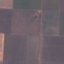

In [5]:
dataset[0][0]

In [14]:
dataset[0][1]

0

In [24]:
dataset.classes

['AnnualCrop',
 'Forest',
 'HerbaceousVegetation',
 'Highway',
 'Industrial',
 'Pasture',
 'PermanentCrop',
 'Residential',
 'River',
 'SeaLake']

In [25]:
len(dataset.classes)

10

### 2. Create custom Dataset class for the given data 
A custom Dataset class must implement three functions: __init__, __len__, and __getitem__.


PyTorch provides two data primitives: **torch.utils.data.DataLoader** and **torch.utils.data.Dataset** that allow you to use pre-loaded datasets as well as your own data.  
Dataset stores the samples and their corresponding labels, and DataLoader wraps an iterable around the Dataset to enable easy access to the samples. (https://pytorch.org/tutorials/beginner/basics/data_tutorial.html)

In [26]:
from torch.utils import data

In [28]:
class EuroSAT(data.Dataset):
    def __init__(self,dataset,transform = None):
        self.dataset = dataset
        self.transform = transform

    def __getitem__(self,index):
        if self.transform:
            x = self.transform(dataset[index][0])
        else:
            x = dataset[index][0]
        y = dataset[index][1]
        return x,y
    
    def __len__(self):
        return len(dataset)


### 3. Create transforms required for the train, val, test split

* We would like to apply 70:15:15 train:val:test split to the data
* We would like to apply different normalizations to the various splits of the data


#### Pytorch Vision transform: <br>
* **torchvision.transforms** is a module that provides common image transformations. <br>
* They can be chained together using **Compose**.

We will be doing the following transforms on the **train** split: 
1. RandomResizedCrop : A crop of random size (default: of 0.08 to 1.0) of the original size and a random aspect ratio (default: of 3/4 to 4/3) of the original aspect ratio is made. This crop is finally resized to given size. 
2. RandomHorizontalFlip : Horizontally flip the given image randomly with a given probability. 
3. RandomVerticalFlip : Vertically flip the given image randomly with a given probability.
4. ToTensor : Convert a PIL Image or numpy.ndarray to tensor. This transform does not support torchscript.
5. Normalize : Normalize a tensor image with mean and standard deviation. 


In [ ]:
from IPython.display import Image

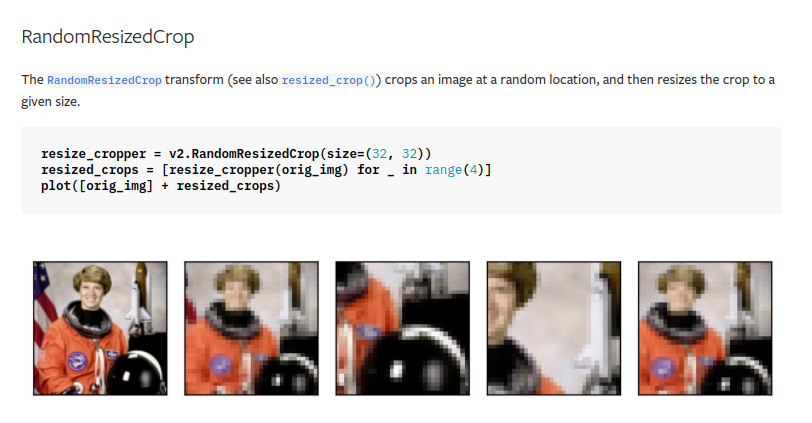

In [ ]:
Image(filename='/home/nirzaree/Pictures/Screenshot from 2024-09-04 18-35-49.png') 

In [ ]:
from torchvision import transforms

In [ ]:
input_size = 224
imagenet_mean,imagenet_std = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]

In [ ]:
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(input_size),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(imagenet_mean,imagenet_std)
    ]
)

We will be doing the following transforms on the **val** and **test** split: 
1. Resize : 
2. CenterCrop : Horizontally flip the given image randomly with a given probability. 
3. ToTensor : Convert a PIL Image or numpy.ndarray to tensor. This transform does not support torchscript.
4. Normalize : Normalize a tensor image with mean and standard deviation. 

In [ ]:
val_transform = transforms.Compose([
    transforms.Resize(input_size),
    transforms.CenterCrop(input_size),
    transforms.ToTensor(),
    transforms.Normalize(imagenet_mean,imagenet_std)
    ]
)

test_transform = transforms.Compose([
    transforms.Resize(input_size),
    transforms.CenterCrop(input_size),
    transforms.ToTensor(),
    transforms.Normalize(imagenet_mean,imagenet_std)
    ]
)

#### One way to do the data split would be to:
    1. create 3 dataset (EuroSAT class) instances of the complete data and run them through train, val and test transforms resp. 
    2. Slice the 3 instances based on the required ratio 

### 4. Create train, val and test instances of the complete dataset using EuroSAT class and then apply the train_transform,val_transform and test_transforms

In [29]:
train_data = EuroSAT(dataset,train_transform) 
val_data = EuroSAT(dataset,val_transform)
test_data = EuroSAT(dataset,test_transform)

In [32]:
train_size = 0.70
val_size = 0.15

In [33]:
len(dataset)

27000

### 5. Shuffle indices and slice the 3 datasets to the required sizes

In [39]:
indices = list(range(len(dataset)))

In [40]:
train_split = int(train_size * len(dataset))
val_split = int(val_size * len(dataset))

In [41]:
import numpy as np

In [42]:
np.random.shuffle(indices)

In [44]:
# indices

In [45]:
train_data = data.Subset(train_data,indices = indices[:train_split])
val_data =  data.Subset(val_data,indices = indices[train_split:train_split + val_split])
test_data = data.Subset(test_data,indices = indices[train_split + val_split:])

In [47]:
print(len(train_data),len(val_data),len(test_data))

18900 4050 4050


In [57]:
# train_data[0][0].numpy()

Let's plot a sample

In [54]:
import matplotlib.pyplot as plt

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


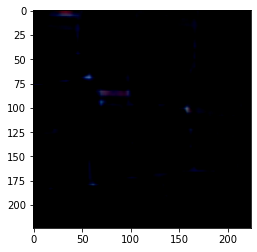

In [59]:
plt.imshow(train_data[0][0].numpy().T) #why transpose: https://stackoverflow.com/questions/65324466/typeerror-invalid-shape-3-32-32-for-image-data-showing-a-colored-image-in

### 6. Create a DataLoader of the data splits

In [60]:
num_workers = 2
batch_size = 16

train_loader = data.DataLoader(
    train_data,
    batch_size = batch_size,
    num_workers=num_workers,
    shuffle = True
)

val_loader = data.DataLoader(
    val_data,
    batch_size = batch_size,
    num_workers=num_workers,
    shuffle = False
)

train_loader = data.DataLoader(
    train_data,
    batch_size = batch_size,
    num_workers=num_workers,
    shuffle = False
)

In [61]:
class_names = dataset.classes
class_names

['AnnualCrop',
 'Forest',
 'HerbaceousVegetation',
 'Highway',
 'Industrial',
 'Pasture',
 'PermanentCrop',
 'Residential',
 'River',
 'SeaLake']

In [65]:
imagenet_mean

[0.485, 0.456, 0.406]

### 6. Plot some training samples

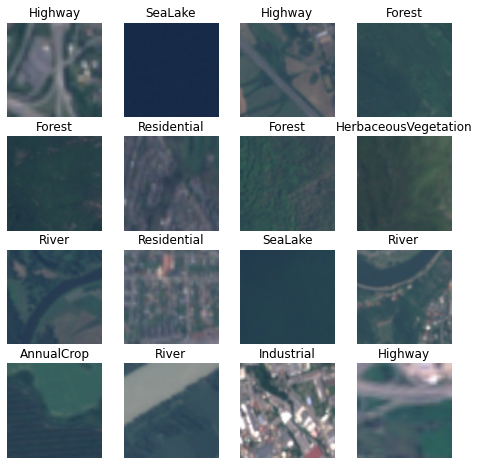

In [68]:
n = 4
inputs, classes = next(iter(train_loader))
fig, axes = plt.subplots(n,n,figsize = (8,8))

for i in range(n):
    for j in range(n):
        image = inputs[i * n + j].numpy().T
        image = np.clip(image * np.array(imagenet_std) + np.array(imagenet_mean),0,1)
        title = class_names[classes[i * n + j]]
        axes[i,j].imshow(image)
        axes[i,j].set_title(title)
        axes[i,j].axis('off')

        

In the next notebook, we build the model. Let's summarize the steps and the functions/classes used in this notebook. 

1. Load data into **ImageFolder** class : **torchvision.datasets.ImageFolder**
2. Create custom Dataset class: **torch.utils.data.Dataset** Custom class implements 3 functions (__init__, __getitem__, __len__)
3. Create sequence of transforms for train, val, test data : **torchvision.transforms** (train_transform,val_transform, test_transform)
4. Create train_data, val_data and test_data instances of the complete dataset using the custom dataset class (EuroSAT) and then apply the train_transform,val_transform and test_transforms. 
5. shuffle the indices (= length of the dataset), and then slice the train_data, val_data, test_data to the required sizes (70%,15%,15%). : **np.random.shuffle**, 
**torch.utils.data.Subset**
6. Create dataloader (train_loader, val_loader, test_loader) on the datasets (train_data,val_data,test_data) for a given batch_size  : **torch.utils.data.DataLoader** 